In [18]:
try:
    import gdown
except:
    !pip install gdown
    import gdown

fid = '1V2XEyLiNBv2GsqG4SFUQVACqCUZ6h3w4'
gdown.download(f"https://drive.google.com/uc?id={fid}", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1V2XEyLiNBv2GsqG4SFUQVACqCUZ6h3w4
To: /home/jovyan/ohw21-proj-deep-currents/notebooks/dataset-duacs-rep-global-merged-allsat-phy-l4_1628139790857.nc
361MB [00:01, 232MB/s]  


'dataset-duacs-rep-global-merged-allsat-phy-l4_1628139790857.nc'

In [19]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import gsw

import requests
from bs4 import BeautifulSoup
from datetime import datetime,timedelta
import fsspec

In [26]:
BOX = [-68.8,-67.8,37,38]

## MUR - SST data

In [68]:
file_location = 's3://mur-sst/zarr'
sst = (
    xr.open_zarr(fsspec.get_mapper(file_location, anon=True),consolidated=True)
    .sel(lon=slice(BOX[0],BOX[1],4),lat=slice(BOX[2],BOX[3],4))
)
sst

<xarray.Dataset>
Dimensions:           (time: 6443, lat: 26, lon: 25)
Coordinates:
  * lat               (lat) float32 37.0 37.04 37.08 37.12 ... 37.92 37.96 38.0
  * lon               (lon) float32 -68.79 -68.75 -68.71 ... -67.87 -67.83
  * time              (time) datetime64[ns] 2002-06-01T09:00:00 ... 2020-01-2...
Data variables:
    analysed_sst      (time, lat, lon) float32 dask.array<chunksize=(6443, 1, 20), meta=np.ndarray>
    analysis_error    (time, lat, lon) float32 dask.array<chunksize=(6443, 1, 20), meta=np.ndarray>
    mask              (time, lat, lon) int8 dask.array<chunksize=(6443, 1, 20), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<chunksize=(6443, 1, 20), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.7
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Resolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    ...                         ...
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    time_coverage_end:          20200116T210000Z
    time_coverage_start:        20200115T210000Z
    title:                      Daily MUR SST, Final product
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0

## SSH data

In [69]:
ssh = xr.open_dataset('dataset-duacs-rep-global-merged-allsat-phy-l4_1628139790857.nc')
with xr.set_options(keep_attrs=True):
    ssh = ssh.assign({'longitude':(((ssh.longitude + 180) % 360) - 180)})
    
ssh = ssh.sel(longitude=slice(BOX[0],BOX[1]),latitude=slice(BOX[2],BOX[3]))
ssh

<xarray.Dataset>
Dimensions:    (time: 1096, latitude: 4, longitude: 4)
Coordinates:
  * time       (time) datetime64[ns] 2008-01-01 2008-01-02 ... 2010-12-31
  * latitude   (latitude) float32 37.12 37.38 37.62 37.88
  * longitude  (longitude) float32 -68.62 -68.38 -68.12 -67.88
Data variables:
    adt        (time, latitude, longitude) float64 ...
    ugos       (time, latitude, longitude) float64 ...
    vgos       (time, latitude, longitude) float64 ...
    vgosa      (time, latitude, longitude) float64 ...
    err        (time, latitude, longitude) float64 ...
    sla        (time, latitude, longitude) float64 ...
    ugosa      (time, latitude, longitude) float64 ...
Attributes: (12/45)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    time_coverage_duration:          P1D
    time_coverage_end:               2020-06-03T00:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2020-06-03T00:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...
    History:                         Translated to CF-1.0 Conventions by Netc...

## Plot time-averaged SST and SSH

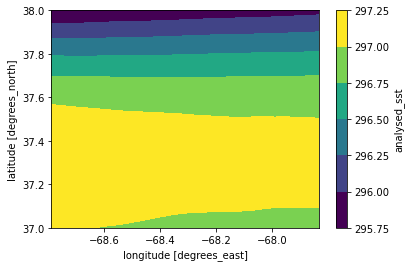

In [70]:
sst.analysed_sst.mean('time').plot.contourf('lon','lat',robust=True)

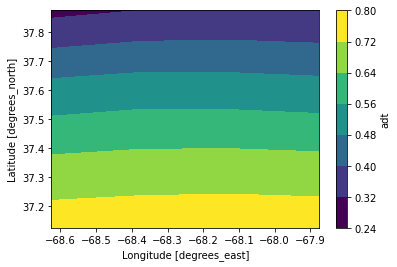

In [71]:
ssh.adt.mean('time').plot.contourf('longitude','latitude',robust=True)

## Line-W data

In [72]:
soup = BeautifulSoup(requests.get("https://dods.ndbc.noaa.gov/thredds/catalog/data/oceansites/DATA/LINE-W/catalog.html").content, "html.parser")

In [73]:
data = [tt.text for tt in soup.find_all('tt') if '.nc' and 'VEL' in tt.text]
uv = xr.open_dataset('https://dods.ndbc.noaa.gov/thredds/dodsC/data/oceansites/DATA/LINE-W/'+data[0],decode_times=False)
uv = uv.assign_coords(TIME=('TIME',[datetime(1950,1,1)+timedelta(days=day) for day in uv.TIME.data]))
uv

<xarray.Dataset>
Dimensions:    (TIME: 34407, DEPTH: 8, LATITUDE: 1, LONGITUDE: 1)
Coordinates:
  * TIME       (TIME) datetime64[ns] 2008-05-16T02:15:00 ... 2010-05-02T21:15...
  * DEPTH      (DEPTH) float32 260.0 770.0 1.27e+03 ... 4.02e+03 4.6e+03
  * LATITUDE   (LATITUDE) float32 37.47
  * LONGITUDE  (LONGITUDE) float32 -68.3
Data variables:
    TEMP       (TIME, DEPTH) float32 ...
    TEMP_QC    (TIME, DEPTH) int8 ...
    PRES       (TIME, DEPTH) float32 ...
    PRES_QC    (TIME, DEPTH) int8 ...
    UCUR       (TIME, DEPTH) float32 ...
    UCUR_QC    (TIME, DEPTH) int8 ...
    VCUR       (TIME, DEPTH) float32 ...
    VCUR_QC    (TIME, DEPTH) int8 ...
Attributes: (12/42)
    platform_code:                 LINE-W6
    site_code:                     LINE-W
    data_mode:                     D
    title:                         LINE-W Mooring Data: Current Meters
    summary:                       Oceanographic mooring data from Line-W in ...
    naming_authority:              OceanSITES
    ...                            ...
    license:                       Follows CLIVAR(Climate Variability and Pre...
    citation:                      These data were collected and made freely ...
    acknowledgement:               Line W was begun with an initial grant fro...
    date_created:                  2017-06-15T15:05:18Z
    history:                       Mooring deployed  15-May-2008; recovered 1...
    QC_indicator:                  good_data

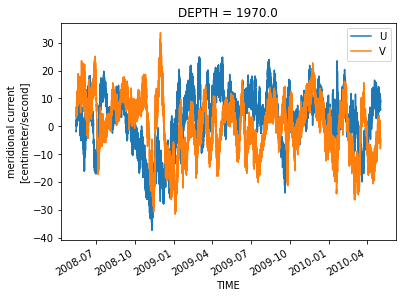

In [74]:
fig,ax = plt.subplots()
uv.UCUR.sel(DEPTH=2000, method='nearest').plot(ax=ax,label='U')
uv.VCUR.sel(DEPTH=2000, method='nearest').plot(ax=ax,label='V')
ax.legend()

## Subset SSH and SST to the mooring time range

In [75]:
sst = sst.sel(time=uv.TIME,method='nearest').load()
ssh = ssh.sel(time=uv.TIME,method='nearest')

Text(0.5, 1.0, 'SST')

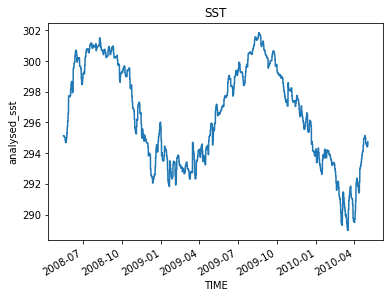

In [79]:
sst.mean(['lat', 'lon']).analysed_sst.plot()
plt.title('SST')

Text(0.5, 1.0, 'SSH')

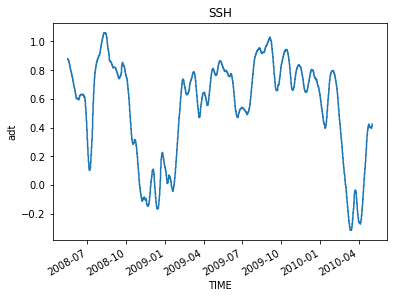

In [80]:
ssh.mean(['latitude', 'longitude']).adt.plot()
plt.title('SSH')

In [11]:
current.UCUR.values.shape

(34407, 8)

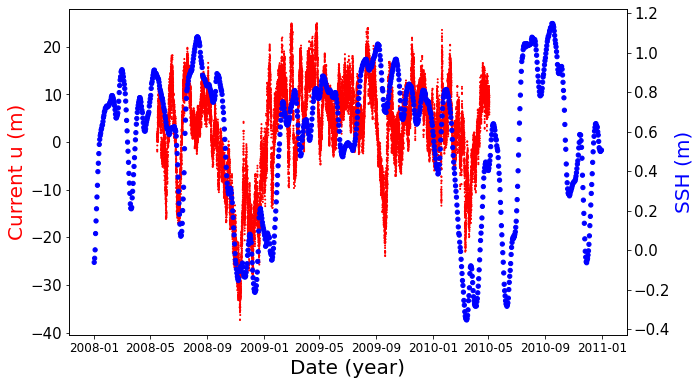

In [12]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
s = [1]*len(current.TIME) # markersize
s1 = [18]*len(ssh.time)

ax.scatter(current.TIME.values, current.UCUR.sel(DEPTH=2000, method='nearest'), s=s, color='r')
ax.set_xlabel('Date (year)', fontsize=20)
ax.set_ylabel('Current u (m)', color='red', fontsize=20)
plt.xticks(fontsize=12);
plt.yticks(fontsize=15);

ax2 = ax.twinx()
ax2.scatter(ssh.time.values, ssh.mean(dim={'latitude', 'longitude'}).adt, s=s1, color='b')
ax2.set_ylabel('SSH (m)', color='b', fontsize=20)
plt.yticks(fontsize=15);

plt.show()

## Linear regression

In [24]:
current_daily_mean_u = current.UCUR.resample(TIME='1D').mean()
current_daily_mean_u

<xarray.DataArray 'UCUR' (TIME: 717, DEPTH: 8)>
array([[ 2.4528441 ,  2.0602198 ,  2.0000882 , ...,  1.3108661 ,
        -0.23224598,  0.2874016 ],
       [-3.6206386 ,  2.2425249 ,  3.4695454 , ...,  5.1513953 ,
         3.6993825 ,  1.0692059 ],
       [-6.788429  , -1.1698383 ,  5.852528  , ...,  9.212497  ,
         8.465543  ,  4.406416  ],
       ...,
       [49.76787   , 23.015745  , 12.510123  , ...,  3.1932003 ,
         1.9736938 ,  0.4349887 ],
       [52.02716   , 24.926702  , 13.830269  , ...,  3.8564813 ,
         1.9894466 ,  0.35938475],
       [52.15872   , 22.542187  , 13.282367  , ...,  2.643682  ,
         1.6656728 ,  0.09595174]], dtype=float32)
Coordinates:
  * TIME     (TIME) datetime64[ns] 2008-05-16 2008-05-17 ... 2010-05-02
  * DEPTH    (DEPTH) float32 260.0 770.0 1.27e+03 ... 3.15e+03 4.02e+03 4.6e+03

In [25]:
ssh_sub = ssh.sel(time=current_daily_mean_u.TIME) # match time

In [27]:
current_daily_mean_u.sel(DEPTH=2000, method='nearest')

<xarray.DataArray 'UCUR' (TIME: 717)>
array([ 7.44490683e-01,  3.49165606e+00,  6.72359085e+00,  8.40996456e+00,
        7.45772982e+00,  6.65459299e+00,  6.67208481e+00,  4.17846537e+00,
        3.82048249e+00, -1.79053974e+00, -2.16359639e+00, -3.16840196e+00,
        6.12258732e-01,  3.17291236e+00,  2.45025039e+00, -2.00323033e+00,
       -3.03682637e+00, -4.93544388e+00, -8.97349453e+00, -1.04518147e+01,
       -6.38893127e+00, -2.36098313e+00, -1.13015234e+00,  1.66337550e+00,
        4.28920984e+00,  6.12472534e+00,  7.28443193e+00,  8.45523071e+00,
        1.15703516e+01,  1.13136301e+01,  1.21411180e+01,  1.37874985e+01,
        1.39678240e+01,  1.22937698e+01,  9.16838455e+00,  5.67610025e+00,
        5.04111814e+00,  3.04826641e+00,  2.39678597e+00,  1.66895771e+00,
       -3.87056381e-01, -7.15362930e+00, -9.84538651e+00, -1.31278458e+01,
       -1.40889215e+01, -1.26350565e+01, -1.32571344e+01, -1.39161987e+01,
       -1.27972460e+01, -9.50841427e+00, -6.94129229e+00, -4.48505068e+00,
       -2.04137516e+00,  2.15399075e+00,  4.19968176e+00,  7.56474686e+00,
        1.13493452e+01,  1.14588814e+01,  1.26956530e+01,  1.31395073e+01,
        1.33302164e+01,  1.22629995e+01,  1.27356720e+01,  1.27108803e+01,
        1.53657112e+01,  1.67744331e+01,  1.45471525e+01,  1.33454447e+01,
        1.43371353e+01,  1.17116976e+01,  9.84878731e+00,  9.30169487e+00,
        7.44331503e+00,  6.02224970e+00,  3.68055367e+00,  3.34231925e+00,
        3.49127579e+00,  3.82945180e+00,  4.33131933e+00,  3.66633415e+00,
...
       -1.21119392e+00, -5.47699630e-01,  7.40068257e-01, -7.72617519e-01,
       -2.11130098e-01,  2.85504365e+00,  2.05689287e+00,  5.03094435e+00,
        3.73933578e+00,  4.59660673e+00,  4.78873205e+00,  5.17336798e+00,
        8.77482176e-01, -2.45743012e+00, -2.91172481e+00, -2.48538613e+00,
       -1.81439066e+00,  3.80751419e+00,  2.75100446e+00,  1.84945476e+00,
        1.52493942e+00,  1.52435672e+00, -4.04084176e-01, -5.07355118e+00,
       -1.53433104e+01, -1.90403805e+01, -1.36810827e+01, -8.00194931e+00,
       -7.44856453e+00, -6.62128496e+00, -7.63900995e+00, -1.05836945e+01,
       -1.43724642e+01, -1.63739471e+01, -1.34260979e+01, -1.37037010e+01,
       -1.18876381e+01, -1.02602959e+01, -7.20254183e+00, -4.59634733e+00,
       -4.08910513e+00, -3.62420177e+00, -2.84036231e+00, -1.70771122e+00,
       -1.83048439e+00, -3.18780732e+00, -6.60151529e+00, -6.21574402e+00,
       -2.89866066e+00, -8.01254272e-01,  1.68055117e+00,  1.29679155e+00,
        2.10085082e+00,  1.43256998e+00,  1.92486954e+00,  2.89389491e+00,
        5.61627579e+00,  8.14121532e+00,  7.87894630e+00,  8.72237110e+00,
        8.78239918e+00,  8.83532333e+00,  1.24449463e+01,  1.17539778e+01,
        1.25173483e+01,  1.22590408e+01,  1.08171349e+01,  1.08311090e+01,
        9.18097782e+00,  8.74625301e+00,  9.22529697e+00,  8.47598457e+00,
        9.43748665e+00,  8.78736591e+00,  9.71656227e+00,  9.63260651e+00,
        8.96040726e+00], dtype=float32)
Coordinates:
  * TIME     (TIME) datetime64[ns] 2008-05-16 2008-05-17 ... 2010-05-02
    DEPTH    float32 1.97e+03

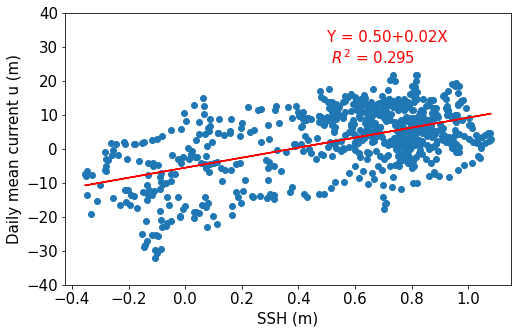

In [64]:
fig1, ax = plt.subplots()
fig1.set_size_inches(8, 5)

y = current_daily_mean_u.sel(DEPTH=2000, method='nearest')
x = ssh_sub.adt.mean(dim={'latitude', 'longitude'})
m, b = np.polyfit(x, y, 1)

ax.plot(x, m*x+b, 'r')
ax.scatter(x, y)

ax.set_ylabel('Daily mean current u (m)', fontsize=15)
ax.set_xlabel('SSH (m)', fontsize=15)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.ylim(-40, 40);
plt.text(0.5, 25, 'Y = 0.50+0.02X\n $R^2$ = 0.295', fontsize=15, color='r')

plt.show()

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

In [44]:
x = current_daily_mean_u.sel(DEPTH=2000, method='nearest').values.reshape((-1,1))
y = ssh_sub.adt.mean(dim={'latitude', 'longitude'})

model = LinearRegression().fit(x, y)

In [45]:
model.score(x,y) # R^2
print("The linear model is: Y = {:.5} + {:.5}X".format(model.intercept_, model.coef_[0]))

The linear model is: Y = 0.49724 + 0.019996X


In [49]:
## R^2 and p-value
X = current_daily_mean_u.sel(DEPTH=2000, method='nearest').values
y = ssh_sub.adt.mean(dim={'latitude', 'longitude'}).values

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     299.1
Date:                Thu, 05 Aug 2021   Prob (F-statistic):           3.06e-56
Time:                        05:55:51   Log-Likelihood:                -160.21
No. Observations:                 717   AIC:                             324.4
Df Residuals:                     715   BIC:                             333.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4972      0.012     42.527      0.0